# LangGraph V1.0 Quickstart

이 튜토리얼은 간단한 설정부터 완전히 작동하는 AI 에이전트까지 단계별로 안내합니다.

환경 변수를 설정해야 원활하게 동작합니다.
이를 설정하기 위해서는 `.env` 에 키를 추가해야 합니다.

In [1]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("LangChain-V1-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangChain-V1-Tutorial


## 모델 이름 지정

모델 이름을 지정할 때 다음 형식을 사용할 수 있습니다:

### 기본 형식

단순히 모델 이름만 지정:
* `'o3-mini'`
* `'claude-sonnet-4-5'`

### 통합 형식

모델 제공자와 모델을 함께 지정할 수 있습니다:

```
'{model_provider}:{model}'
```

**예시:**
* `'openai:o1'`
* `'anthropic:claude-sonnet-4-5'`

이 형식을 사용하면 하나의 인자로 모델 제공자와 모델을 동시에 명시할 수 있습니다.

**주요 파라미터**

* **temperature**: 출력의 무작위성을 조절하는 모델 온도 값
* **max_tokens**: 생성할 최대 토큰 수
* **timeout**: 응답 대기 최대 시간 (초 단위)
* **max_retries**: 요청 실패 시 최대 재시도 횟수
* **base_url**: 커스텀 API endpoint URL
* **rate_limiter**: 요청 속도를 제어하는 BaseRateLimiter 인스턴스

### 사용 예시

```python
model_kwargs = {
    "temperature": 0.7,
    "max_tokens": 1000,
    "timeout": 30
}
```

> **참고**: 사용 가능한 전체 파라미터 목록은 각 모델 제공자의 integration reference를 참조하세요.

- [공식문서](https://reference.langchain.com/python/langchain/models/?_gl=1*kundig*_gcl_au*MjAwMTM0Mzc1Mi4xNzYxNDEwNDky*_ga*MTI0ODcwNDIuMTc2MTgwNjA5Mg..*_ga_47WX3HKKY2*czE3NjE4MDYwNzUkbzUkZzEkdDE3NjE4MDYxMjEkajE0JGwwJGgw#langchain.chat_models.init_chat_model)

In [3]:
from langchain.chat_models import init_chat_model

# model 인스턴스 생성
llm = init_chat_model("openai:gpt-4.1", temperature=0)

In [4]:
from langchain_teddynote.messages import stream_response

result = llm.stream("반가워")
# 스트리밍 출력
stream_response(result)

반가워! 무엇을 도와드릴까요? 😊

## 에이전트 생성

LangGraph 기반의 에이전트를 사용합니다. 과거 `create_react_agent` 대신 `create_agent` 를 사용합니다.

In [5]:
from langchain.agents import create_agent

# 모델 식별자 문자열을 사용한 간단한 방법
agent = create_agent("openai:gpt-4.1-mini", tools=[])

만들어진 그래프 시각화

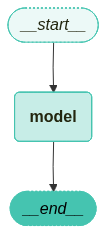

In [6]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(agent)

메시지 출력

In [7]:
from langchain_teddynote.messages import stream_graph
from langchain_core.messages import HumanMessage

stream_graph(agent, inputs={"messages": [HumanMessage(content="안녕하세요?")]})


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! 어떻게 도와드릴까요?

## 기본 에이전트 구축

질문에 답하고 도구를 호출할 수 있는 간단한 에이전트를 만듭니다. 

기본 날씨 함수(실제로 기능이 있는 도구는 아닙니다!) 를 도구로 사용하며, 간단한 프롬프트로 동작을 안내합니다.

In [8]:
from langchain.tools import tool
from langchain.agents import create_agent


# 날씨 정보를 반환하는 간단한 함수
@tool
def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"


# 에이전트 생성
agent = create_agent(
    model="openai:gpt-4.1-mini",
    tools=[get_weather],
    system_prompt="You are a helpful assistant",
)

그래프 시각화

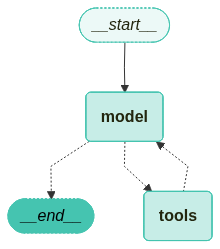

In [9]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(agent)

스트리밍 답변 출력

In [10]:
# 에이전트 실행
stream_graph(agent, inputs={"messages": [HumanMessage(content="서울 날씨가 어때?")]})


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
It's always sunny in 서울!
🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
서울은 현재 맑은 날씨입니다. 더 궁금한 점 있으면 알려주세요!

## 도구(Tool)

도구를 사용하면 모델이 정의한 함수를 호출하여 외부 시스템과 상호작용할 수 있습니다. 

도구는 런타임 컨텍스트에 의존할 수 있으며 에이전트 메모리와 상호작용할 수도 있습니다.

### 컨택스트(Context)

컨택스트는 도구에 전달되는 추가 정보를 제공합니다. 

`runtime.context` 를 통해 컨택스트에 접근할 수 있습니다.

```python
runtime.context.user_id
```

In [11]:
from dataclasses import dataclass
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.tools import tool, ToolRuntime


USER_DATABASE = {
    "teddy": {
        "name": "Teddy Lee",
        "account_type": "Premium",
        "balance": 5000,
        "email": "teddy@example.com",
    },
    "shirley": {
        "name": "Shirley Kim",
        "account_type": "Standard",
        "balance": 1200,
        "email": "shirley@example.com",
    },
}


@dataclass
class UserContext:
    user_id: str


@tool
def get_account_info(runtime: ToolRuntime[UserContext]) -> str:
    """Get the current user's account information."""
    user_id = runtime.context.user_id

    if user_id in USER_DATABASE:
        user = USER_DATABASE[user_id]
        return f"Account holder: {user['name']}\nType: {user['account_type']}\nBalance: ${user['balance']}"
    return "User not found"


model = ChatOpenAI(model="gpt-4o")
agent = create_agent(
    model,
    tools=[get_account_info],
    context_schema=UserContext,
    system_prompt="You are a financial assistant.",
)

In [12]:
from langchain_teddynote.messages import stream_graph
from langchain_core.messages import HumanMessage

stream_graph(
    agent,
    inputs={"messages": [HumanMessage(content="내 계좌의 현재 잔고를 알려주세요.")]},
    context=UserContext(user_id="teddy"),
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Account holder: Teddy Lee
Type: Premium
Balance: $5000
🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
현재 계좌 잔고는 $5,000입니다.

## 응답 형식(Response Format)

에이전트 응답이 특정 스키마와 일치하도록 구조화된 응답 형식을 정의합니다.

참고: dataclass 또는 pydantic 모델을 사용하여 응답 형식을 정의할 수 있습니다.

In [13]:
from pydantic import BaseModel, Field


class ResponseFormat(BaseModel):
    """Response schema for the agent."""

    email_sender: str = Field(description="The sender of the email")
    email_sender_address: str = Field(description="The address of the sender")

In [14]:
# 모든 구성요소를 포함한 에이전트 생성
agent = create_agent(
    model=llm,
    system_prompt="Extract useful information from the email.",
    tools=[],
    response_format=ResponseFormat,
)

sample_input = """From: 김철수 (chulsoo.kim@bikecorporation.me)
Subject: "ZENESIS" 자전거 유통 협력 및 미팅 일정 제안

안녕하세요, 이은채 대리님,

저는 바이크코퍼레이션의 김철수 상무입니다. 최근 보도자료를 통해 귀사의 신규 자전거 "ZENESIS"에 대해 알게 되었습니다. 바이크코퍼레이션은 자전거 제조 및 유통 분야에서 혁신과 품질을 선도하는 기업으로, 이 분야에서의 장기적인 경험과 전문성을 가지고 있습니다.

ZENESIS 모델에 대한 상세한 브로슈어를 요청드립니다. 특히 기술 사양, 배터리 성능, 그리고 디자인 측면에 대한 정보가 필요합니다. 이를 통해 저희가 제안할 유통 전략과 마케팅 계획을 보다 구체화할 수 있을 것입니다.

또한, 협력 가능성을 더 깊이 논의하기 위해 다음 주 화요일(1월 15일) 오전 10시에 미팅을 제안합니다. 귀사 사무실에서 만나 이야기를 나눌 수 있을까요?

감사합니다.

김철수
상무이사
바이크코퍼레이션
"""

# 첫 번째 질문: 날씨 문의
response = agent.invoke(
    {"messages": [HumanMessage(content=sample_input)]},
)
print(response["messages"][-1].content)
print("===" * 10)
print(response["structured_response"])

{"email_sender":"김철수","email_sender_address":"chulsoo.kim@bikecorporation.me"}
email_sender='김철수' email_sender_address='chulsoo.kim@bikecorporation.me'


## 단기 메모리 추가

에이전트에 메모리를 추가하여 상호작용 간에 상태를 유지합니다. 이를 통해 에이전트는 이전 대화와 컨텍스트를 기억할 수 있습니다.

단기 기억의 유지의 범위는 `thread_id` 로 관리 합니다. 즉, 동일한 `thread_id` 는 동일한 메모리를 공유합니다.

참고: 프로덕션 환경에서는 데이터베이스에 저장하는 영구 체크포인터를 사용하세요.

In [15]:
from langgraph.checkpoint.memory import InMemorySaver

# 메모리 체크포인터 생성
checkpointer = InMemorySaver()

In [16]:
# 모든 구성요소를 포함한 에이전트 생성
agent = create_agent(
    model=llm,
    checkpointer=checkpointer,
)

# thread_id는 특정 대화의 고유 식별자입니다.
config = {"configurable": {"thread_id": "1"}}


stream_graph(
    agent,
    inputs={"messages": [HumanMessage(content="안녕, 내 이름은 테디야")]},
    config=config,
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕, 테디! 만나서 반가워. 😊  
무엇을 도와줄까?

In [17]:
stream_graph(
    agent,
    inputs={"messages": [HumanMessage(content="내 이름이 뭔지 기억나?")]},
    config=config,
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네! 네 이름은 **테디**라고 했지. 😊  
혹시 더 궁금한 게 있으면 언제든 말해줘!

In [18]:
stream_graph(
    agent,
    inputs={"messages": [HumanMessage(content="내 이름이 뭔지 기억나?")]},
    config={"configurable": {"thread_id": "2"}},
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
내가 너의 이름을 알 수 없어. 이전 대화에서 네 이름을 말해줬다면, 그 정보를 기억하지 못해. 내가 대화를 이어가긴 하지만, 개인정보나 이전 대화 내용을 저장하지 않아. 네가 원한다면 이름을 알려줄 수 있어!

## 미들웨어(Middleware)

미들웨어는 에이전트 실행의 모든 단계를 제어하고 커스터마이징하는 방법을 제공합니다.

핵심 에이전트 루프는 모델을 호출하고, 모델이 실행할 도구를 선택하도록 한 다음, 더 이상 도구를 호출하지 않으면 종료하는 것을 포함합니다.

![](./assets/langgraph-middleware.avif)

미들웨어는 각 단계 전후에 후크를 노출합니다.

- 에이전트 시작 전/후
- 모델 호출 전/후
- 도구 실행 전/후

## Human in the Loop Middleware

### 개요

Human in the Loop Middleware는 AI 시스템의 의사결정 과정에 사람의 개입을 가능하게 하는 중간 계층입니다. 자동화된 프로세스 중 특정 시점에서 사람의 검토, 승인 또는 수정을 요구할 수 있습니다.

### 주요 특징

* **검증 단계 추가**: AI의 출력을 사람이 검토하고 승인하는 단계 삽입
* **오류 방지**: 중요한 결정에 대한 사람의 최종 확인으로 오류 최소화
* **유연한 개입**: 필요에 따라 자동/수동 모드 전환 가능
* **피드백 루프**: 사람의 수정 사항을 학습 데이터로 활용

### Parameters

#### `timeout`
* **타입**: `int` 또는 `float`
* **기본값**: `None`
* **설명**: 사람의 응답을 기다리는 최대 시간(초)
* **사용법**: timeout 초과 시 기본 동작 실행 또는 예외 발생
```python
middleware = HumanInTheLoopMiddleware(timeout=300)  # 5분
```

#### `approval_required`
* **타입**: `bool`
* **기본값**: `True`
* **설명**: 사람의 명시적 승인이 필요한지 여부
* **사용법**: `False`로 설정 시 검토만 하고 자동 진행
```python
middleware = HumanInTheLoopMiddleware(approval_required=True)
```

#### `callback_function`
* **타입**: `callable`
* **기본값**: `None`
* **설명**: 사람의 개입이 필요할 때 호출되는 함수
* **사용법**: 알림, 로깅, UI 표시 등의 커스텀 동작 정의
```python
def notify_user(data):
    print(f"Review needed: {data}")

middleware = HumanInTheLoopMiddleware(callback_function=notify_user)
```

#### `intervention_condition`
* **타입**: `callable` 또는 `str`
* **기본값**: `"always"`
* **설명**: 사람 개입이 필요한 조건 정의
* **사용법**: 함수 또는 조건 문자열로 지정
```python
# 함수로 조건 정의
def check_confidence(result):
    return result.confidence < 0.8

middleware = HumanInTheLoopMiddleware(intervention_condition=check_confidence)

# 문자열로 조건 정의
middleware = HumanInTheLoopMiddleware(intervention_condition="low_confidence")
```

#### `retry_limit`
* **타입**: `int`
* **기본값**: `3`
* **설명**: 사람의 응답을 요청하는 최대 재시도 횟수
* **사용법**: 응답이 없을 때 재시도 횟수 제한
```python
middleware = HumanInTheLoopMiddleware(retry_limit=5)
```

#### `fallback_action`
* **타입**: `str` 또는 `callable`
* **기본값**: `"reject"`
* **설명**: timeout 또는 응답 실패 시 수행할 동작
* **옵션**: `"approve"`, `"reject"`, `"skip"`, 또는 커스텀 함수
* **사용법**:
```python
middleware = HumanInTheLoopMiddleware(fallback_action="approve")

# 커스텀 fallback
def custom_fallback(context):
    return context.get("default_value")

middleware = HumanInTheLoopMiddleware(fallback_action=custom_fallback)
```

#### `notification_channels`
* **타입**: `list`
* **기본값**: `["console"]`
* **설명**: 알림을 전송할 채널 목록
* **옵션**: `"console"`, `"email"`, `"slack"`, `"webhook"` 등
* **사용법**:
```python
middleware = HumanInTheLoopMiddleware(
    notification_channels=["email", "slack"]
)
```

#### `store_feedback`
* **타입**: `bool`
* **기본값**: `True`
* **설명**: 사람의 피드백을 저장할지 여부
* **사용법**: 학습 데이터로 활용하기 위해 피드백 저장
```python
middleware = HumanInTheLoopMiddleware(store_feedback=True)
```

#### `priority_level`
* **타입**: `str` 또는 `int`
* **기본값**: `"normal"`
* **설명**: 개입 요청의 우선순위
* **옵션**: `"low"`, `"normal"`, `"high"`, `"critical"` 또는 1-5
* **사용법**:
```python
middleware = HumanInTheLoopMiddleware(priority_level="high")
```

In [19]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command
from langchain.tools import tool


@tool
def search_tool(query: str) -> str:
    """Search for information."""
    return f"Search results for: {query}"


@tool
def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Send an email. This is a sensitive operation."""
    return f"Email sent to {recipient}"


@tool
def delete_database_tool(database_name: str) -> str:
    """Delete a database. This is a critical operation."""
    return f"Database {database_name} deleted"


agent = create_agent(
    model=llm,
    tools=[search_tool, send_email_tool, delete_database_tool],
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                # 민감한 작업에 대해 승인 필요
                "send_email_tool": True,
                "delete_database_tool": True,
                # 안전한 작업은 자동 승인
                "search_tool": False,
            }
        ),
    ],
    checkpointer=InMemorySaver(),  # 상태 지속성 필요
)

# thread_id 필요
config = {"configurable": {"thread_id": "123"}}

In [20]:
from langchain_teddynote.messages import invoke_graph

invoke_graph(
    agent,
    inputs={
        "messages": [
            HumanMessage(
                content="teddy@example.com 에게 메일을 보내 주세요. 제목은 '테스트' 이고 내용은 '안녕하세요' 입니다."
            )
        ]
    },
    config=config,
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  send_email_tool (call_nw0YjNBkjj02CMbtoZPgGbME)
 Call ID: call_nw0YjNBkjj02CMbtoZPgGbME
  Args:
    recipient: teddy@example.com
    subject: 테스트
    body: 안녕하세요

🔄 Node: __interrupt__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Interrupt(value={'action_requests': [{'name': 'send_email_tool', 'args': {'recipient': 'teddy@example.com', 'subject': '테스트', 'body': '안녕하세요'}, 'description': "Tool execution requires approval\n\nTool: send_email_tool\nArgs: {'recipient': 'teddy@example.com', 'subject': '테스트', 'body': '안녕하세요'}"}], 'review_configs': [{'action_name': 'send_email_tool', 'allowed_decisions': ['approve', 'edit', 'reject']}]}, id='9f4cd50e781ec98ab4af42c937904771')


In [21]:
# interrupt 확인
print(agent.get_state(config).interrupts[0].value["action_requests"][0]["description"])

Tool execution requires approval

Tool: send_email_tool
Args: {'recipient': 'teddy@example.com', 'subject': '테스트', 'body': '안녕하세요'}


In [22]:
# decisions: approve, reject, skip
stream_graph(
    agent, inputs=Command(resume={"decisions": [{"type": "approve"}]}), config=config
)


🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Email sent to teddy@example.com
🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
teddy@example.com에게 제목이 '테스트'이고, 내용이 '안녕하세요'인 메일을 보냈습니다.